# 计算网络参数
本例中采用交叉熵损失函数（也称负对数似然函数）。我们有$N$个样本，对应$C$个分类，那么预测值$\hat{y}\hat{y}$与实际值$y$之间的损失函数为：
$$
L(y,\hat{y}) = -\frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} log \hat{y}_{n,i}
$$

本例中使用随机梯度下降算法来寻找损失函数的最小值。为了方便编码和实现，此处使用一个固定的学习率$\eta$实现批量梯度下降算法：
$$
x \leftarrow x - \eta \Delta x
$$
上式中$\Delta x$对$x$进行求导，因此批量梯度下降首先需要对该人工神经网络模型中用到的参数$W_1 、 b_1 、 W_2 、 b_2$进行求导：
$$
\frac{\partial L}{\partial W_1}, \quad
\frac{\partial L}{\partial b_1}, \quad
\frac{\partial L}{\partial W_2}, \quad
\frac{\partial L}{\partial b_2}
$$
对权重和偏置参数进行求则是利用BP反向传播算法。得到网络中的各个参数的偏导：
$$
\delta _3 = \hat{y} - y   \\
\delta _2 = (1 - \tanh^2 z_1) \delta _3 W_{2}^{T}    \\
\frac{\partial L}{\partial W_2} = a_{1}^{T} \delta _3    \\
\frac{\partial L}{\partial b_2} = \delta _3    \\
\frac{\partial L}{\partial W_1} = x^{T} \delta _2    \\
\frac{\partial L}{\partial b_1} = \delta _2
$$


## 定义参数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

input_dim = 2 # 输入的维度
output_dim = 2 # 输出的维度， 分类数

epsilon = 0.01 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化强度

## 损失函数
下面实现 calculate_loss() 损失函数。 model 字典中存储着网络中的权重参数和偏置参数，通过 model 获取网络中的参数 $W_1, b_1, W_2, b_2$, 使用神经网络的潜亏公式进行前馈计算。前馈计算后得到的预测值为 probs 。 再用 probs 与真实的输出值 y 来计算损失值。

In [2]:
def calculate_loss(model, X, y):
    '''损失函数'''

    num_examples = len(X) # 训练集大小
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # 使用正向传播计算预测值
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # 计算损失值
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    # 对损失值进行归一化
    data_loss += reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1. / num_examples * data_loss


## 预测函数
对于预测函数 predict() , 预测时只需要对模型进行一次向前传播，然后返回分类结果中概率值最大的一项。

In [3]:
def predict(model, x):
    '''预测函数'''

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 向前传播
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

## 反向传播算法计算梯度下降

In [4]:
def ANN_model(X, y, nn_hdim):
    '''
    人工神经网络模型函数
    - nn_hdim: 隐层的神经元节点（隐层的数目）
    '''

    num_indim = len(X) # 用于训练网络的输入数据
    model = {} # 模型存储定义
    
    # 随机初始化网络中的权重参数w1, w2 和偏置 b1, b2
    np.random.seed(0)
    W1 = np.random.randn(input_dim, nn_hdim) / np.sqrt(input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, output_dim) / np.sqrt(input_dim)
    b2 = np.zeros((1, output_dim))

    # 批量梯度下降算法BSGD
    num_passes = 20000 # 梯度下降迭代次数
    for i in range(0, num_passes):
        # 向前传播
        z1 = X.dot(W1) + b1 # M[200*2] * M[2*3] --> M[200*3]
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2 # M[200*3] * M[3*2] --> M[200*2]
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # 向后传播算法
        delta3 = probs # 得到的预测值  [200*2]
        delta3[range(num_indim), y] -= 1
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2)) # [200*3]
        dW2 = (a1.T).dot(delta3) # [3*2]
        db2 = np.sum(delta3, axis=0, keepdims=True) # b2的导数 [200*1]
        dW1 = np.dot(X.T, delta2) # W1的导数 [2*3]
        db1 = np.sum(delta2, axis=0) # b1的导数 

        # 添加正则化项
        dW1 += reg_lambda * W1
        dW2 += reg_lambda * W2

        # 根据梯度下降算法更新权重
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # 把新写的参数写入model 字典中进行记录
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        if i % 1000 == 0:
            print("Loss after iteration %i: %f", i, calculate_loss(model, X, y))

    return model

## 绘制图形

In [5]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

## 仿真数据生成

In [6]:
def generate_data():
    np.random.seed(0)
    # X : array of shape [n_samples, 2] The generated samples.
    # y : array of shape [n_samples] The integer labels (0 or 1) 
    # for class membership of each sample.
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

Loss after iteration %i: %f 0 0.4204441660831049
Loss after iteration %i: %f 1000 0.06896994001258885
Loss after iteration %i: %f 2000 0.06975017332825625
Loss after iteration %i: %f 3000 0.07075621626697692
Loss after iteration %i: %f 4000 0.07075117651238075
Loss after iteration %i: %f 5000 0.07075347600059877
Loss after iteration %i: %f 6000 0.07075595592779921
Loss after iteration %i: %f 7000 0.07075762787442991
Loss after iteration %i: %f 8000 0.07075858034118471
Loss after iteration %i: %f 9000 0.07075904048135907
Loss after iteration %i: %f 10000 0.07075919675137197
Loss after iteration %i: %f 11000 0.07075917922057752
Loss after iteration %i: %f 12000 0.07075907106644963
Loss after iteration %i: %f 13000 0.07075892288171554
Loss after iteration %i: %f 14000 0.07075876400086567
Loss after iteration %i: %f 15000 0.07075861042443223
Loss after iteration %i: %f 16000 0.07075847005843394
Loss after iteration %i: %f 17000 0.07075834606100447
Loss after iteration %i: %f 18000 0.070758

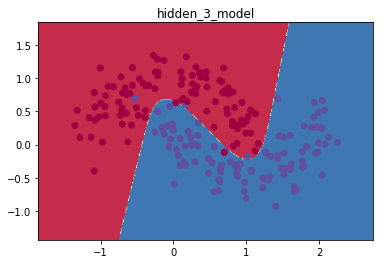

In [7]:
# 执行该人工神经网络模型代码
X, y = generate_data()
hidden_3_model = ANN_model(X, y, 3)
plt.title("hidden_3_model")
plot_decision_boundary(lambda x: predict(hidden_3_model, x), X, y)

## 隐层节点数对人工神经网络模型的影响

Loss after iteration %i: %f 0 0.5864895601056758
Loss after iteration %i: %f 1000 0.3284171646421799
Loss after iteration %i: %f 2000 0.3284075510452116
Loss after iteration %i: %f 3000 0.32839968017643656
Loss after iteration %i: %f 4000 0.32839323611856214
Loss after iteration %i: %f 5000 0.32838796022296857
Loss after iteration %i: %f 6000 0.3283836407281941
Loss after iteration %i: %f 7000 0.3283801042603517
Loss after iteration %i: %f 8000 0.32837720887432775
Loss after iteration %i: %f 9000 0.3283748383564548
Loss after iteration %i: %f 10000 0.32837289755998084
Loss after iteration %i: %f 11000 0.328371308586113
Loss after iteration %i: %f 12000 0.32837000765735186
Loss after iteration %i: %f 13000 0.3283689425576193
Loss after iteration %i: %f 14000 0.32836807053643396
Loss after iteration %i: %f 15000 0.32836735659301214
Loss after iteration %i: %f 16000 0.3283667720714224
Loss after iteration %i: %f 17000 0.3283662935104069
Loss after iteration %i: %f 18000 0.3283659017017047

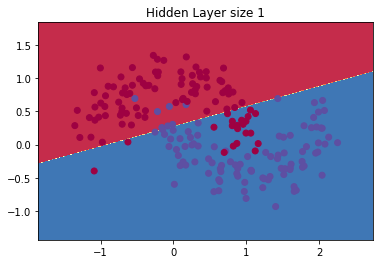

Loss after iteration %i: %f 0 0.5465442859821488
Loss after iteration %i: %f 1000 0.32409262520058724
Loss after iteration %i: %f 2000 0.32125120941524316
Loss after iteration %i: %f 3000 0.32266089825130523
Loss after iteration %i: %f 4000 0.3219101491440563
Loss after iteration %i: %f 5000 0.3235251465789464
Loss after iteration %i: %f 6000 0.340599342563077
Loss after iteration %i: %f 7000 0.29502687678771106
Loss after iteration %i: %f 8000 0.3213878379894866
Loss after iteration %i: %f 9000 0.37623223238792997
Loss after iteration %i: %f 10000 0.3262787906343639
Loss after iteration %i: %f 11000 0.37217266254981113
Loss after iteration %i: %f 12000 0.31358558242991175
Loss after iteration %i: %f 13000 0.35169711346662036
Loss after iteration %i: %f 14000 0.36276295654852697
Loss after iteration %i: %f 15000 0.2962133046103548
Loss after iteration %i: %f 16000 0.32142543085111824
Loss after iteration %i: %f 17000 0.32444451673248537
Loss after iteration %i: %f 18000 0.3261003707114

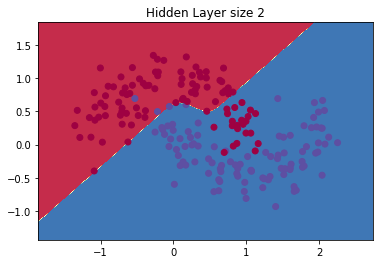

Loss after iteration %i: %f 0 0.4204441660831049
Loss after iteration %i: %f 1000 0.06896994001258885
Loss after iteration %i: %f 2000 0.06975017332825625
Loss after iteration %i: %f 3000 0.07075621626697692
Loss after iteration %i: %f 4000 0.07075117651238075
Loss after iteration %i: %f 5000 0.07075347600059877
Loss after iteration %i: %f 6000 0.07075595592779921
Loss after iteration %i: %f 7000 0.07075762787442991
Loss after iteration %i: %f 8000 0.07075858034118471
Loss after iteration %i: %f 9000 0.07075904048135907
Loss after iteration %i: %f 10000 0.07075919675137197
Loss after iteration %i: %f 11000 0.07075917922057752
Loss after iteration %i: %f 12000 0.07075907106644963
Loss after iteration %i: %f 13000 0.07075892288171554
Loss after iteration %i: %f 14000 0.07075876400086567
Loss after iteration %i: %f 15000 0.07075861042443223
Loss after iteration %i: %f 16000 0.07075847005843394
Loss after iteration %i: %f 17000 0.07075834606100447
Loss after iteration %i: %f 18000 0.070758

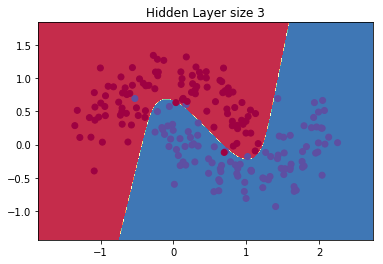

Loss after iteration %i: %f 0 0.4462104083880148
Loss after iteration %i: %f 1000 0.06685739732403437
Loss after iteration %i: %f 2000 0.058745721018685
Loss after iteration %i: %f 3000 0.05648108063789209
Loss after iteration %i: %f 4000 0.0552481962161574
Loss after iteration %i: %f 5000 0.0544812739727733
Loss after iteration %i: %f 6000 0.05402893148076411
Loss after iteration %i: %f 7000 0.053777259670005795
Loss after iteration %i: %f 8000 0.05364051641807737
Loss after iteration %i: %f 9000 0.053566313433549326
Loss after iteration %i: %f 10000 0.05352568952346791
Loss after iteration %i: %f 11000 0.05350316503397095
Loss after iteration %i: %f 12000 0.05349050061334792
Loss after iteration %i: %f 13000 0.053483276160636875
Loss after iteration %i: %f 14000 0.05347909192282428
Loss after iteration %i: %f 15000 0.05347662838139769
Loss after iteration %i: %f 16000 0.05347515108999144
Loss after iteration %i: %f 17000 0.05347424654743984
Loss after iteration %i: %f 18000 0.0534736

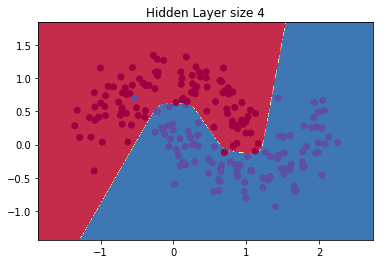

Loss after iteration %i: %f 0 1.9670056952974622
Loss after iteration %i: %f 1000 0.04660717545839312
Loss after iteration %i: %f 2000 0.039181569868566614
Loss after iteration %i: %f 3000 0.03643348329914371
Loss after iteration %i: %f 4000 0.035124833140432445
Loss after iteration %i: %f 5000 0.03439840308433415
Loss after iteration %i: %f 6000 0.03392663645316375
Loss after iteration %i: %f 7000 0.0335806184827439
Loss after iteration %i: %f 8000 0.03329845913773002
Loss after iteration %i: %f 9000 0.03301673876179371
Loss after iteration %i: %f 10000 0.03268844533066213
Loss after iteration %i: %f 11000 0.03236666683569605
Loss after iteration %i: %f 12000 0.03208867091840407
Loss after iteration %i: %f 13000 0.03183545903790282
Loss after iteration %i: %f 14000 0.0316142638378888
Loss after iteration %i: %f 15000 0.0314230418663885
Loss after iteration %i: %f 16000 0.0312458416699174
Loss after iteration %i: %f 17000 0.031076592754292035
Loss after iteration %i: %f 18000 0.0309190

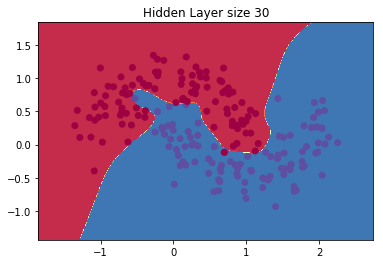

Loss after iteration %i: %f 0 0.6783849153925526
Loss after iteration %i: %f 1000 0.05008889980059701
Loss after iteration %i: %f 2000 0.0400170531580676
Loss after iteration %i: %f 3000 0.03734053459721557
Loss after iteration %i: %f 4000 0.03588286617551569
Loss after iteration %i: %f 5000 0.03485926453138731
Loss after iteration %i: %f 6000 0.034061857707851424
Loss after iteration %i: %f 7000 0.033404174664117436
Loss after iteration %i: %f 8000 0.03284088818397908
Loss after iteration %i: %f 9000 0.03234352298746571
Loss after iteration %i: %f 10000 0.03190456433603032
Loss after iteration %i: %f 11000 0.03153060298374709
Loss after iteration %i: %f 12000 0.031218004477116965
Loss after iteration %i: %f 13000 0.03095678238278757
Loss after iteration %i: %f 14000 0.030736774098583084
Loss after iteration %i: %f 15000 0.030549461990071185
Loss after iteration %i: %f 16000 0.030388364123264577
Loss after iteration %i: %f 17000 0.03024883507339066
Loss after iteration %i: %f 18000 0.0

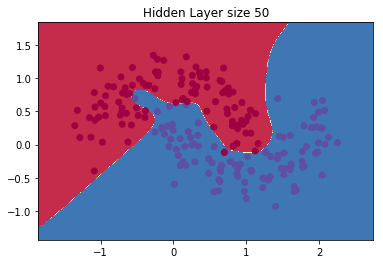

In [9]:
# 待输入隐层节点数目
hidden_layer_dimensions = [1,2,3,4,30,50]

for i,nn_hdim in enumerate(hidden_layer_dimensions):
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = ANN_model(X, y, nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x), X, y)

随着隐层节点数目的增加，过度拟合的可能性越高。

## 学习速率对人工神经网络的影响

Loss after iteration %i: %f 0 0.4204441660831049
Loss after iteration %i: %f 1000 0.06896994001258885
Loss after iteration %i: %f 2000 0.06975017332825625
Loss after iteration %i: %f 3000 0.07075621626697692
Loss after iteration %i: %f 4000 0.07075117651238075
Loss after iteration %i: %f 5000 0.07075347600059877
Loss after iteration %i: %f 6000 0.07075595592779921
Loss after iteration %i: %f 7000 0.07075762787442991
Loss after iteration %i: %f 8000 0.07075858034118471
Loss after iteration %i: %f 9000 0.07075904048135907
Loss after iteration %i: %f 10000 0.07075919675137197
Loss after iteration %i: %f 11000 0.07075917922057752
Loss after iteration %i: %f 12000 0.07075907106644963
Loss after iteration %i: %f 13000 0.07075892288171554
Loss after iteration %i: %f 14000 0.07075876400086567
Loss after iteration %i: %f 15000 0.07075861042443223
Loss after iteration %i: %f 16000 0.07075847005843394
Loss after iteration %i: %f 17000 0.07075834606100447
Loss after iteration %i: %f 18000 0.070758

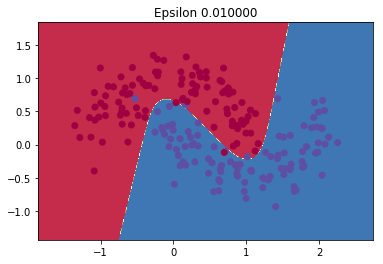

Loss after iteration %i: %f 0 0.37070530993493317
Loss after iteration %i: %f 1000 0.07065224966819371
Loss after iteration %i: %f 2000 0.07241700522396975
Loss after iteration %i: %f 3000 0.07091160070425129
Loss after iteration %i: %f 4000 0.07110370969770817
Loss after iteration %i: %f 5000 0.07217781418614747
Loss after iteration %i: %f 6000 0.07358654037789716
Loss after iteration %i: %f 7000 0.07098469568715791
Loss after iteration %i: %f 8000 0.0721212382794679
Loss after iteration %i: %f 9000 0.07347395784717888
Loss after iteration %i: %f 10000 0.07526686740767537
Loss after iteration %i: %f 11000 0.07124274134453368
Loss after iteration %i: %f 12000 0.07131379778543698
Loss after iteration %i: %f 13000 0.07277479302509109
Loss after iteration %i: %f 14000 0.07104960532653533
Loss after iteration %i: %f 15000 0.07180754838095353
Loss after iteration %i: %f 16000 0.07280605345411632
Loss after iteration %i: %f 17000 0.07464312738020837
Loss after iteration %i: %f 18000 0.071450

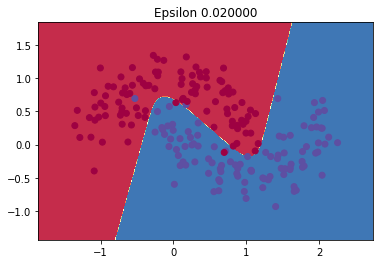

Loss after iteration %i: %f 0 0.37340738322416583
Loss after iteration %i: %f 1000 0.0792889915761209
Loss after iteration %i: %f 2000 0.07490954241750732
Loss after iteration %i: %f 3000 0.07633235330553925
Loss after iteration %i: %f 4000 0.07399701524059428
Loss after iteration %i: %f 5000 0.07555600728863845
Loss after iteration %i: %f 6000 0.07742734852971792
Loss after iteration %i: %f 7000 0.07398740962995494
Loss after iteration %i: %f 8000 0.07614280144543041
Loss after iteration %i: %f 9000 0.07403659916409773
Loss after iteration %i: %f 10000 0.0748762682511483
Loss after iteration %i: %f 11000 0.0764807995740722
Loss after iteration %i: %f 12000 0.07909140198002215
Loss after iteration %i: %f 13000 0.07447349196466864
Loss after iteration %i: %f 14000 0.07603038680574443
Loss after iteration %i: %f 15000 0.08248798401414537
Loss after iteration %i: %f 16000 0.07527811212531887
Loss after iteration %i: %f 17000 0.07683666299475998
Loss after iteration %i: %f 18000 0.07384448

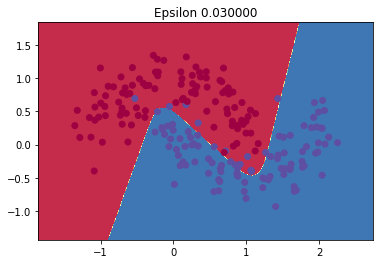

Loss after iteration %i: %f 0 0.7882171753417103
Loss after iteration %i: %f 1000 3.4425876331670437
Loss after iteration %i: %f 2000 2.504051610168693
Loss after iteration %i: %f 3000 3.032517548298667
Loss after iteration %i: %f 4000 2.3695391502612133
Loss after iteration %i: %f 5000 0.8991431632135131
Loss after iteration %i: %f 6000 2.0357063048968085
Loss after iteration %i: %f 7000 3.3763354247908346
Loss after iteration %i: %f 8000 1.1462678431659048
Loss after iteration %i: %f 9000 2.059316266643137
Loss after iteration %i: %f 10000 1.6690491799144311
Loss after iteration %i: %f 11000 1.5481545210365228
Loss after iteration %i: %f 12000 1.3101907323150397
Loss after iteration %i: %f 13000 1.3500718965578447
Loss after iteration %i: %f 14000 1.6756568312848081
Loss after iteration %i: %f 15000 1.6889115897526898
Loss after iteration %i: %f 16000 0.7662948923393762
Loss after iteration %i: %f 17000 1.6533299475304708
Loss after iteration %i: %f 18000 3.6407437783780585
Loss afte

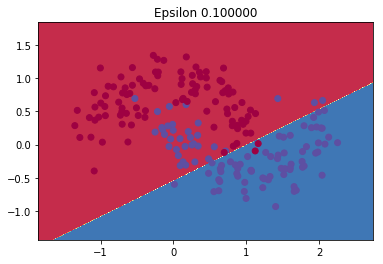

Loss after iteration %i: %f 0 1.6519771515084436
Loss after iteration %i: %f 1000 12.549917930785668
Loss after iteration %i: %f 2000 6.059071006721752
Loss after iteration %i: %f 3000 4.825437548640105
Loss after iteration %i: %f 4000 5.004539279629036
Loss after iteration %i: %f 5000 4.835273528298256
Loss after iteration %i: %f 6000 3.948517767075423
Loss after iteration %i: %f 7000 9.278914315773223
Loss after iteration %i: %f 8000 4.298456270891038
Loss after iteration %i: %f 9000 2.8103372897661583
Loss after iteration %i: %f 10000 1.6580569166162569
Loss after iteration %i: %f 11000 5.0593036807110465
Loss after iteration %i: %f 12000 13.777055411117972
Loss after iteration %i: %f 13000 4.115338659044302
Loss after iteration %i: %f 14000 9.655067169705637
Loss after iteration %i: %f 15000 6.8784751914643465
Loss after iteration %i: %f 16000 3.07938498234675
Loss after iteration %i: %f 17000 3.6216902491546588
Loss after iteration %i: %f 18000 3.328211564605504
Loss after iterati

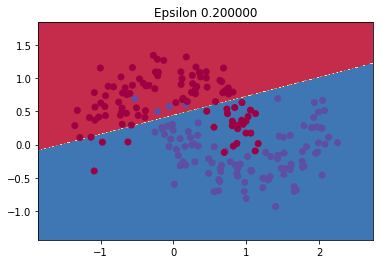

Loss after iteration %i: %f 0 2.6873810315709
Loss after iteration %i: %f 1000 25.539937104522682
Loss after iteration %i: %f 2000 11.088798466423764
Loss after iteration %i: %f 3000 9.880527551939707
Loss after iteration %i: %f 4000 5.595559064009873
Loss after iteration %i: %f 5000 23.965503700220033
Loss after iteration %i: %f 6000 13.951050718689695
Loss after iteration %i: %f 7000 11.835049908252048
Loss after iteration %i: %f 8000 15.979657655577968
Loss after iteration %i: %f 9000 17.76964277412898
Loss after iteration %i: %f 10000 16.695817888584422
Loss after iteration %i: %f 11000 14.579813756126912
Loss after iteration %i: %f 12000 15.094167721669326
Loss after iteration %i: %f 13000 22.739980375637646
Loss after iteration %i: %f 14000 24.09199529582198
Loss after iteration %i: %f 15000 23.39494027373239
Loss after iteration %i: %f 16000 13.714428814529333
Loss after iteration %i: %f 17000 13.11582173368878
Loss after iteration %i: %f 18000 14.536886973324442
Loss after iter

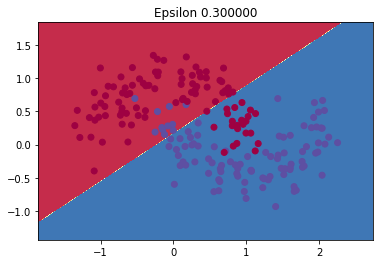

Loss after iteration %i: %f 0 4.803490147740872
Loss after iteration %i: %f 1000 93.0869093555597
Loss after iteration %i: %f 2000 93.49134148686174
Loss after iteration %i: %f 3000 93.4940327737912
Loss after iteration %i: %f 4000 93.49405068153905
Loss after iteration %i: %f 5000 93.49405080069674
Loss after iteration %i: %f 6000 93.49405080148946
Loss after iteration %i: %f 7000 93.4940508014947
Loss after iteration %i: %f 8000 93.4940508014947
Loss after iteration %i: %f 9000 93.4940508014947
Loss after iteration %i: %f 10000 93.4940508014947
Loss after iteration %i: %f 11000 93.4940508014947
Loss after iteration %i: %f 12000 93.4940508014947
Loss after iteration %i: %f 13000 93.4940508014947
Loss after iteration %i: %f 14000 93.4940508014947
Loss after iteration %i: %f 15000 93.4940508014947
Loss after iteration %i: %f 16000 93.4940508014947
Loss after iteration %i: %f 17000 93.4940508014947
Loss after iteration %i: %f 18000 93.4940508014947
Loss after iteration %i: %f 19000 93.49

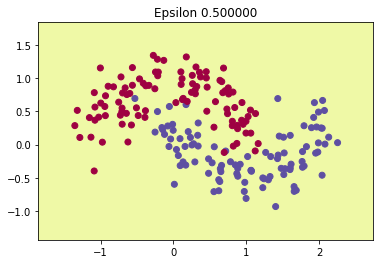

Loss after iteration %i: %f 0 10.065562032565046
Loss after iteration %i: %f 1000 209.86347377004873
Loss after iteration %i: %f 2000 206.60587343663346
Loss after iteration %i: %f 3000 206.6057329393881
Loss after iteration %i: %f 4000 206.60573293332308
Loss after iteration %i: %f 5000 206.60573293332308
Loss after iteration %i: %f 6000 206.60573293332308
Loss after iteration %i: %f 7000 206.60573293332308
Loss after iteration %i: %f 8000 206.60573293332308
Loss after iteration %i: %f 9000 206.60573293332308
Loss after iteration %i: %f 10000 206.60573293332308
Loss after iteration %i: %f 11000 206.60573293332308
Loss after iteration %i: %f 12000 206.60573293332308
Loss after iteration %i: %f 13000 206.60573293332308
Loss after iteration %i: %f 14000 206.60573293332308
Loss after iteration %i: %f 15000 206.60573293332308
Loss after iteration %i: %f 16000 206.60573293332308
Loss after iteration %i: %f 17000 206.60573293332308
Loss after iteration %i: %f 18000 206.60573293332308
Loss af

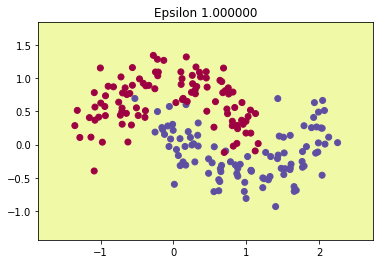

In [10]:
# 不同学习速率对人工神经网络的影响
epsilon = 0.01 # 梯度下降的学习率
epsilons = [0.01, 0.02, 0.03, 0.1, 0.2, 0.3, 0.5, 1]
for i in epsilons:
    epsilon = i
    plt.title("Epsilon %f" % epsilon)
    model = ANN_model(X, y, nn_hdim = 3)
    plot_decision_boundary(lambda x: predict(model, x), X, y)


Loss after iteration %i: %f 0 0.4204441660831049
Loss after iteration %i: %f 1000 0.06896994001258885
Loss after iteration %i: %f 2000 0.06975017332825625
Loss after iteration %i: %f 3000 0.07075621626697692
Loss after iteration %i: %f 4000 0.07075117651238075
Loss after iteration %i: %f 5000 0.07075347600059877
Loss after iteration %i: %f 6000 0.07075595592779921
Loss after iteration %i: %f 7000 0.07075762787442991
Loss after iteration %i: %f 8000 0.07075858034118471
Loss after iteration %i: %f 9000 0.07075904048135907
Loss after iteration %i: %f 10000 0.07075919675137197
Loss after iteration %i: %f 11000 0.07075917922057752
Loss after iteration %i: %f 12000 0.07075907106644963
Loss after iteration %i: %f 13000 0.07075892288171554
Loss after iteration %i: %f 14000 0.07075876400086567
Loss after iteration %i: %f 15000 0.07075861042443223
Loss after iteration %i: %f 16000 0.07075847005843394
Loss after iteration %i: %f 17000 0.07075834606100447
Loss after iteration %i: %f 18000 0.070758

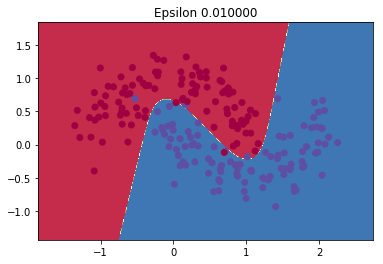

Loss after iteration %i: %f 0 0.44004974856991597
Loss after iteration %i: %f 1000 0.06945854485844921
Loss after iteration %i: %f 2000 0.06838017818309491
Loss after iteration %i: %f 3000 0.06971830849092682
Loss after iteration %i: %f 4000 0.06945755289232582
Loss after iteration %i: %f 5000 0.06947403150276892
Loss after iteration %i: %f 6000 0.06949040229566016
Loss after iteration %i: %f 7000 0.06950252664404316
Loss after iteration %i: %f 8000 0.0695109758971328
Loss after iteration %i: %f 9000 0.0695167107376312
Loss after iteration %i: %f 10000 0.06952053954908412
Loss after iteration %i: %f 11000 0.06952305855693261
Loss after iteration %i: %f 12000 0.06952468830612533
Loss after iteration %i: %f 13000 0.0695257198947711
Loss after iteration %i: %f 14000 0.06952635283444025
Loss after iteration %i: %f 15000 0.06952672293641046
Loss after iteration %i: %f 16000 0.06952692209222949
Loss after iteration %i: %f 17000 0.06952701208178623
Loss after iteration %i: %f 18000 0.06952703

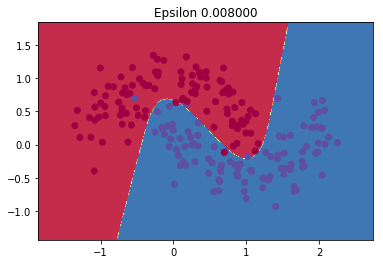

Loss after iteration %i: %f 0 0.45138957791592726
Loss after iteration %i: %f 1000 0.06998095077637305
Loss after iteration %i: %f 2000 0.06850892947342944
Loss after iteration %i: %f 3000 0.06817702789576863
Loss after iteration %i: %f 4000 0.0680273441837905
Loss after iteration %i: %f 5000 0.06794419791084497
Loss after iteration %i: %f 6000 0.0688714542724714
Loss after iteration %i: %f 7000 0.06888343692191605
Loss after iteration %i: %f 8000 0.06890730092637495
Loss after iteration %i: %f 9000 0.06892617741324308
Loss after iteration %i: %f 10000 0.06894004834694055
Loss after iteration %i: %f 11000 0.06895004980570307
Loss after iteration %i: %f 12000 0.06895720826118101
Loss after iteration %i: %f 13000 0.06896230827551789
Loss after iteration %i: %f 14000 0.06896592601873977
Loss after iteration %i: %f 15000 0.06896847965399996
Loss after iteration %i: %f 16000 0.06897027135705822
Loss after iteration %i: %f 17000 0.06897151898850862
Loss after iteration %i: %f 18000 0.0689723

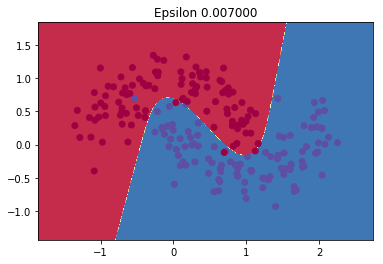

Loss after iteration %i: %f 0 0.4638278807503359
Loss after iteration %i: %f 1000 0.07095280545401644
Loss after iteration %i: %f 2000 0.0687135992319738
Loss after iteration %i: %f 3000 0.06827996067354693
Loss after iteration %i: %f 4000 0.06809573300156373
Loss after iteration %i: %f 5000 0.0679940427171822
Loss after iteration %i: %f 6000 0.06793163838869133
Loss after iteration %i: %f 7000 0.06789129139139427
Loss after iteration %i: %f 8000 0.06786438691552893
Loss after iteration %i: %f 9000 0.06784606004355621
Loss after iteration %i: %f 10000 0.06783337062536153
Loss after iteration %i: %f 11000 0.06782446549422154
Loss after iteration %i: %f 12000 0.06781814226304803
Loss after iteration %i: %f 13000 0.0678136038688028
Loss after iteration %i: %f 14000 0.06815200454838441
Loss after iteration %i: %f 15000 0.06811466268797844
Loss after iteration %i: %f 16000 0.06811100277036367
Loss after iteration %i: %f 17000 0.06811314352104506
Loss after iteration %i: %f 18000 0.068116054

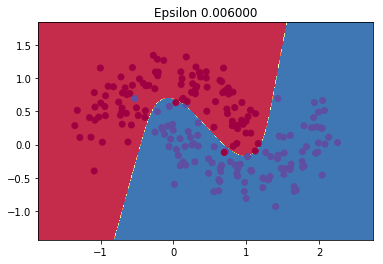

Loss after iteration %i: %f 0 0.4774195132062166
Loss after iteration %i: %f 1000 0.07296049774446829
Loss after iteration %i: %f 2000 0.0691235452272194
Loss after iteration %i: %f 3000 0.0684534688455565
Loss after iteration %i: %f 4000 0.06820248705599935
Loss after iteration %i: %f 5000 0.06806919750242488
Loss after iteration %i: %f 6000 0.0679878934207816
Loss after iteration %i: %f 7000 0.06793468801932409
Loss after iteration %i: %f 8000 0.06789839289756416
Loss after iteration %i: %f 9000 0.06787294066001293
Loss after iteration %i: %f 10000 0.06785473188271521
Loss after iteration %i: %f 11000 0.06784150300027911
Loss after iteration %i: %f 12000 0.06783177166049287
Loss after iteration %i: %f 13000 0.06782453770632485
Loss after iteration %i: %f 14000 0.06781911069608197
Loss after iteration %i: %f 15000 0.06781500531640279
Loss after iteration %i: %f 16000 0.06781187545948121
Loss after iteration %i: %f 17000 0.06780947135898667
Loss after iteration %i: %f 18000 0.067807611

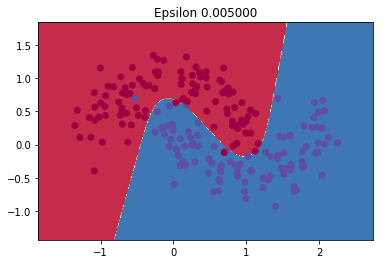

Loss after iteration %i: %f 0 0.562360537831985
Loss after iteration %i: %f 1000 0.3064285873882014
Loss after iteration %i: %f 2000 0.29702790013859115
Loss after iteration %i: %f 3000 0.28449983139604307
Loss after iteration %i: %f 4000 0.2657496387765674
Loss after iteration %i: %f 5000 0.2424666138474506
Loss after iteration %i: %f 6000 0.21891593668053602
Loss after iteration %i: %f 7000 0.19866401111463283
Loss after iteration %i: %f 8000 0.18226796339589071
Loss after iteration %i: %f 9000 0.16911262211173983
Loss after iteration %i: %f 10000 0.1584721036132933
Loss after iteration %i: %f 11000 0.1496996762301169
Loss after iteration %i: %f 12000 0.14220634678588887
Loss after iteration %i: %f 13000 0.13541358040195728
Loss after iteration %i: %f 14000 0.12882823244268216
Loss after iteration %i: %f 15000 0.12229810730774202
Loss after iteration %i: %f 16000 0.11605755998810297
Loss after iteration %i: %f 17000 0.11038024541499264
Loss after iteration %i: %f 18000 0.105357552168

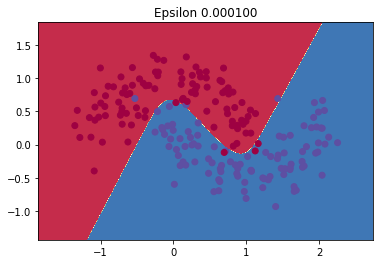

In [11]:
epsilons = [0.01, 0.008, 0.007, 0.006, 0.005, 0.0001]
for i in epsilons:
    epsilon = i
    plt.title("Epsilon %f" % epsilon)
    model = ANN_model(X, y, nn_hdim = 3)
    plot_decision_boundary(lambda x: predict(model, x), X, y)


从上面的可视化图形可以看出，不同的学习速率对学习效果的影响。当步长太大时，会使得效果越来越差，而当小到一定程度时，基本不会有明显的优化